<a href="https://colab.research.google.com/github/IyadSultan/AI_pediatric_oncology/blob/main/jacob_labur_training_MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install opendatasets for easier Kaggle downloading
!pip install opendatasets --quiet

import opendatasets as od
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2
import numpy as np
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, ConfusionMatrixDisplay, roc_curve, auc,
                             precision_recall_curve, average_precision_score)
import matplotlib.pyplot as plt
import os
import pathlib
import time # To time training

print("TF version:", tf.__version__)

TF version: 2.18.0


In [ ]:
# Download the dataset (will ask for Kaggle username and key if needed)
# Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
dataset_url = 'https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia'
od.download(dataset_url, force=True)

# Define the base path where the data got downloaded
data_dir = pathlib.Path('./chest-xray-pneumonia/chest_xray/')
print(f"Data downloaded to: {data_dir}")

# Define paths to train, validation, and test sets
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

print(f"Train directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory: {test_dir}")
#fb41dca493b5a95320c7b74d20a21627

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jacobluber
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


100%|██████████| 2.29G/2.29G [00:25<00:00, 95.7MB/s]



Data downloaded to: chest-xray-pneumonia/chest_xray
Train directory: chest-xray-pneumonia/chest_xray/train
Validation directory: chest-xray-pneumonia/chest_xray/val
Test directory: chest-xray-pneumonia/chest_xray/test


Found 624 files belonging to 2 classes.
Class names: ['NORMAL', 'PNEUMONIA']
Mapping: {0: 'NORMAL', 1: 'PNEUMONIA'}
Number of batches in test_dataset: 20
Searching for 4 NORMAL and 4 PNEUMONIA images...
Collected 4 NORMAL and 4 PNEUMONIA images.


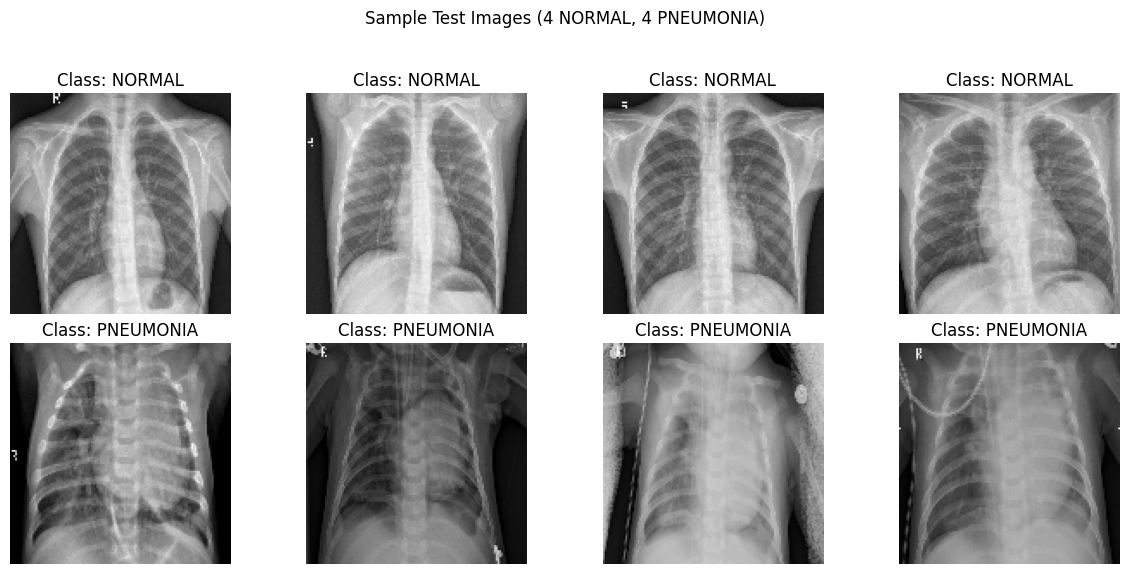

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define image parameters
IMG_HEIGHT = 128 # Resize images to this height
IMG_WIDTH = 128  # Resize images to this width
BATCH_SIZE = 32  # Process images in batches

# Load the test dataset
# `image_dataset_from_directory` infers labels from folder names ('NORMAL', 'PNEUMONIA')
# It loads images, resizes them, and creates batches.
# `shuffle=False` is important for evaluation to keep images and labels aligned.
test_dataset = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  shuffle=False, # Keep order for evaluation
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

# Get class names (will be ['NORMAL', 'PNEUMONIA'] based on folder names)
class_names = test_dataset.class_names
print("Class names:", class_names)
print("Mapping:", {i: name for i, name in enumerate(class_names)})
# Verify mapping: NORMAL should be 0, PNEUMONIA should be 1 (usually alphabetical)

# Check the number of batches in the test set
print(f"Number of batches in test_dataset: {tf.data.experimental.cardinality(test_dataset)}")

# --- Configuration ---
num_samples_per_class = 4  # How many images of each class to display (e.g., 4 NORMAL, 4 PNEUMONIA)
total_samples_needed = num_samples_per_class * 2
max_batches_to_check = 15 # Safety limit to prevent checking the entire dataset if samples aren't found quickly

# --- Data Collection ---
collected_images = []
collected_labels = []
# Keep track of counts for each class index (0 for NORMAL, 1 for PNEUMONIA)
counts = {i: 0 for i in range(len(class_names))}


print(f"Searching for {num_samples_per_class} NORMAL and {num_samples_per_class} PNEUMONIA images...")

# Iterate through the dataset batches
for batch_num, (image_batch, label_batch) in enumerate(test_dataset):
    # Iterate through images and labels within the batch
    for image, label_tensor in zip(image_batch, label_batch):
        label = label_tensor.numpy()  # Get the integer label (0 or 1)

        # Check if we still need samples for this class
        if counts[label] < num_samples_per_class:
            # Store the image (convert for plotting) and label
            collected_images.append(image.numpy().astype("uint8"))
            collected_labels.append(label)
            counts[label] += 1 # Increment count for this class

        # Check if we have collected enough samples overall
        if len(collected_images) >= total_samples_needed:
            break # Stop searching within this batch

    # Check if we have collected enough samples overall OR reached batch limit
    if len(collected_images) >= total_samples_needed or batch_num >= max_batches_to_check:
        break # Stop searching through batches

print(f"Collected {counts.get(0, 0)} NORMAL and {counts.get(1, 0)} PNEUMONIA images.")


# --- Plotting ---
if not collected_images:
    print("No images were collected for plotting.")
else:
    # Determine grid size dynamically
    total_to_plot = len(collected_images)
    ncols = min(total_to_plot, num_samples_per_class) # Max columns = samples per class
    nrows = (total_to_plot + ncols - 1) // ncols # Calculate rows needed

    plt.figure(figsize=(ncols * 3, nrows * 3)) # Adjust figsize based on grid

    for i in range(total_to_plot):
        ax = plt.subplot(nrows, ncols, i + 1)
        plt.imshow(collected_images[i])  # Images were converted during collection
        plt.title(f"Class: {class_names[collected_labels[i]]}") # Use collected label
        plt.axis("off")

    plt.suptitle(f"Sample Test Images ({counts.get(0, 0)} NORMAL, {counts.get(1, 0)} PNEUMONIA)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

In [ ]:
IMG_HEIGHT = 128
IMG_WEIDTH = 128
BATCH_SIZE = 32

train_dataset = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  shuffle=True,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

val_dataset = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  shuffle=True,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  shuffle=True,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

#normal,pneumonia
class_names = train_dataset.class_names
print(class_names)
#

data_augmentation = tf.keras.Sequential(
    [layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.1),], name="data_augmentation")


preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


def preprocess_batch(image, label):
    # Ensure 3 channels (MobileNetV2 expects color)
    if image.shape[-1] == 1:
      image = tf.image.grayscale_to_rgb(image)
    return preprocess_input(image), label

# --- Apply Preprocessing and Augmentation ---
AUTOTUNE = tf.data.AUTOTUNE

# Apply augmentation ONLY to training data
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                                  num_parallel_calls=AUTOTUNE)

# Apply preprocessing to all datasets
train_dataset = train_dataset.map(preprocess_batch, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.map(preprocess_batch, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.map(preprocess_batch, num_parallel_calls=AUTOTUNE)

# Configure datasets for performance
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Datasets loaded and preprocessed.")
# Example batch shape
for image_batch, labels_batch in train_dataset.take(1):
  print("Train batch shape:", image_batch.shape)
  print("Train labels shape:", labels_batch.shape)



Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
['NORMAL', 'PNEUMONIA']
Datasets loaded and preprocessed.
Train batch shape: (32, 128, 128, 3)
Train labels shape: (32,)


In [ ]:
# --- Load Pre-trained Base Model ---
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, # Exclude ImageNet classifier
                                               weights='imagenet')

# --- Freeze the Base Model ---
# We will initially train only the new classifier head
base_model.trainable = False

# --- Add Classification Head ---
# Define input layer matching the base model's expected input
inputs = tf.keras.Input(shape=IMG_SHAPE)
# Pass inputs through the frozen base model
x = base_model(inputs, training=False) # IMPORTANT: training=False for frozen base
# Pool features
x = layers.GlobalAveragePooling2D()(x)
# Optional: Add dropout for regularization
x = layers.Dropout(0.2)(x)
# Final classification layer (1 neuron for binary, sigmoid activation)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Create the final model
model = tf.keras.Model(inputs, outputs)

print("Model built successfully.")
model.summary()



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Model built successfully.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Initial Evaluation (Before Fine-Tuning) ---
Generating initial predictions on the test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 301ms/step
Extracting true labels from the test dataset...
Total true labels extracted: 624

--- Evaluation Results (Before Fine-Tuning) ---


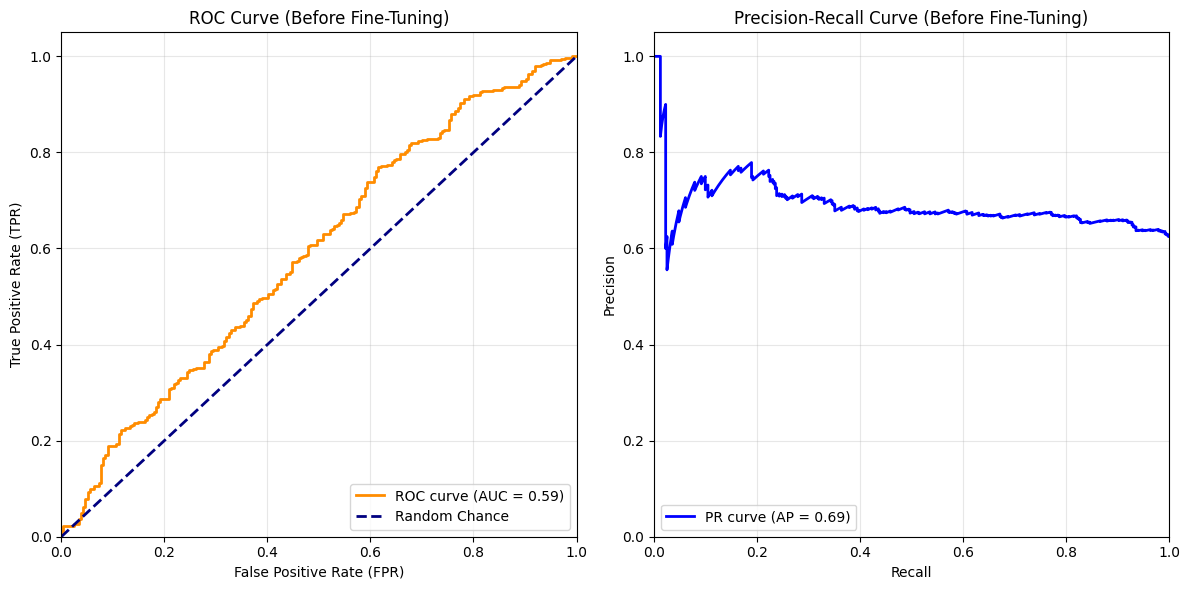

ROC AUC: 0.5905
Average Precision (AP): 0.6917

--- Scalar Metrics @ 0.5 Threshold (Before Fine-Tuning) ---
Confusion Matrix:


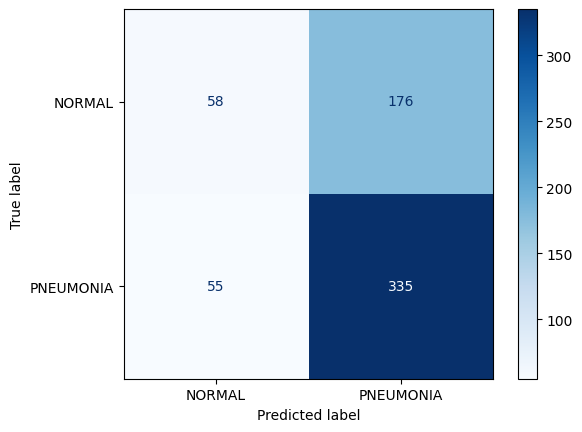

Accuracy: 0.6298
Precision (Pneumonia): 0.6556
Recall (Pneumonia): 0.8590


In [ ]:
# CELL 5 - Initial Evaluation (Before Fine-tuning)

print("\n--- Initial Evaluation (Before Fine-Tuning) ---")

# --- Compile the model (needed for prediction/evaluation) ---
# Use a standard optimizer for this initial phase
initial_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy']) # Basic metric

# --- Generate Predictions ---
print("Generating initial predictions on the test set...")
# Ensure test_dataset is the processed one if preprocessing is done before evaluation
# If you defined test_dataset_processed earlier, use that. Otherwise, use test_dataset.
# Assuming test_dataset includes preprocessing based on previous cells:
y_pred_proba_initial = model.predict(test_dataset) # Use the dataset that matches model input requirements
y_pred_initial = (y_pred_proba_initial.flatten() >= 0.5).astype(int)

# --- Extract True Labels from Test Set ---
# IMPORTANT: This needs to run successfully BEFORE the function call below.
print("Extracting true labels from the test dataset...")
y_true = []
# Iterate directly over the original test_dataset which yields (image_batch, label_batch) tuples
# Ensure this loop uses the NON-preprocessed dataset if y_true needs original labels,
# or ensure labels are passed through preprocessing correctly if using processed dataset.
# Let's assume we iterate the original 'test_dataset' for labels
for image_batch, label_batch in test_dataset:
    # Append the numpy array of labels from the current batch to the list
    y_true.extend(label_batch.numpy())
y_true = np.array(y_true) # Convert the list of all labels to a single numpy array
print(f"Total true labels extracted: {len(y_true)}")
# Make sure y_true is not empty and has the expected number of labels
if len(y_true) == 0:
    raise ValueError("Failed to extract true labels (y_true is empty). Check test_dataset iteration.")


# --- Define Evaluation Function (Ensure class_names is passed if needed) ---
# Based on your error message, you might be passing class_names, so let's include it:
def evaluate_and_plot(y_true_labels, y_pred_probabilities, y_pred_thresholded, class_names_arg, title_suffix=""):
    print(f"\n--- Evaluation Results {title_suffix} ---")

    if len(np.unique(y_true_labels)) < 2:
         print("Warning: Only one class present in true labels. ROC/PR may be misleading.")
         # Set default values to avoid errors in plotting/metrics if only one class
         roc_auc = 0.5
         average_precision = 0.0 # Or calculate based on the single class if appropriate
         fpr, tpr = np.array([0, 1]), np.array([0, 1]) # Default diagonal line
         precision, recall = np.array([0, 1]), np.array([1, 0]) # Default line
    else:
        # --- ROC Curve ---
        fpr, tpr, _ = roc_curve(y_true_labels, y_pred_probabilities.flatten(), pos_label=1)
        roc_auc = auc(fpr, tpr)
        # --- Precision-Recall Curve ---
        precision, recall, _ = precision_recall_curve(y_true_labels, y_pred_probabilities.flatten(), pos_label=1)
        average_precision = average_precision_score(y_true_labels, y_pred_probabilities.flatten(), pos_label=1)

    # --- Plotting ---
    plt.figure(figsize=(12, 6))
    # Plot ROC
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)'); plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'ROC Curve {title_suffix}'); plt.legend(loc="lower right"); plt.grid(alpha=0.3)
    # Plot PR
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
    plt.xlabel('Recall'); plt.ylabel('Precision')
    plt.ylim([0.0, 1.05]); plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curve {title_suffix}'); plt.legend(loc="lower left"); plt.grid(alpha=0.3)
    plt.tight_layout(); plt.show()

    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Average Precision (AP): {average_precision:.4f}")

    # --- Scalar Metrics @ 0.5 Threshold ---
    print(f"\n--- Scalar Metrics @ 0.5 Threshold {title_suffix} ---")
    cm = confusion_matrix(y_true_labels, y_pred_thresholded, labels=[0, 1])
    # Use the passed class_names_arg
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_arg)
    print("Confusion Matrix:")
    disp.plot(cmap=plt.cm.Blues); plt.show()

    accuracy = accuracy_score(y_true_labels, y_pred_thresholded)
    precision_val = precision_score(y_true_labels, y_pred_thresholded, pos_label=1, zero_division=0)
    recall_val = recall_score(y_true_labels, y_pred_thresholded, pos_label=1, zero_division=0)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Pneumonia): {precision_val:.4f}")
    print(f"Recall (Pneumonia): {recall_val:.4f}")


# --- Call evaluation function for initial results ---
# Ensure class_names is defined globally or passed correctly.
# Assuming class_names was defined during dataset loading.
evaluate_and_plot(y_true, y_pred_proba_initial, y_pred_initial, class_names, title_suffix="(Before Fine-Tuning)")


--- Fine-Tuning Phase 1: Training Classifier Head ---
Training the model head for 3 epochs...
Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 52s 267ms/step - accuracy: 0.8040 - loss: 0.4098 - val_accuracy: 0.8125 - val_loss: 0.3237
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9210 - loss: 0.1950 - val_accuracy: 0.8125 - val_loss: 0.2913
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9281 - loss: 0.1730 - val_accuracy: 0.8125 - val_loss: 0.2695
Phase 1 training completed in 56.47 seconds.


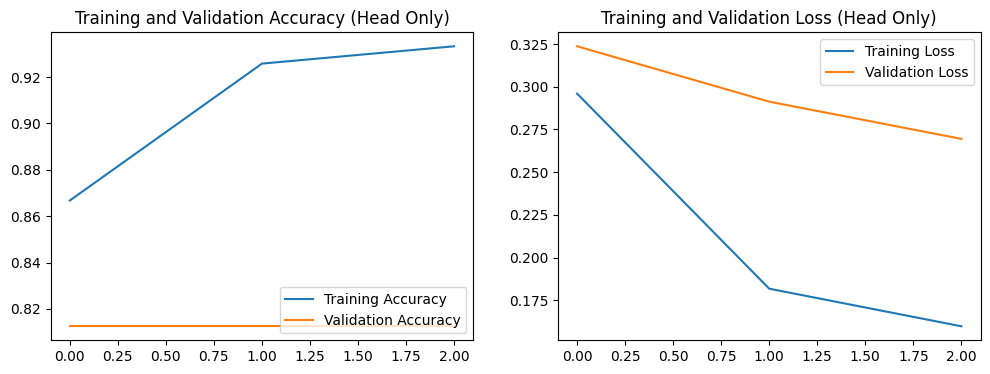

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step

--- Evaluation Results (After All Fine-Tuning) ---


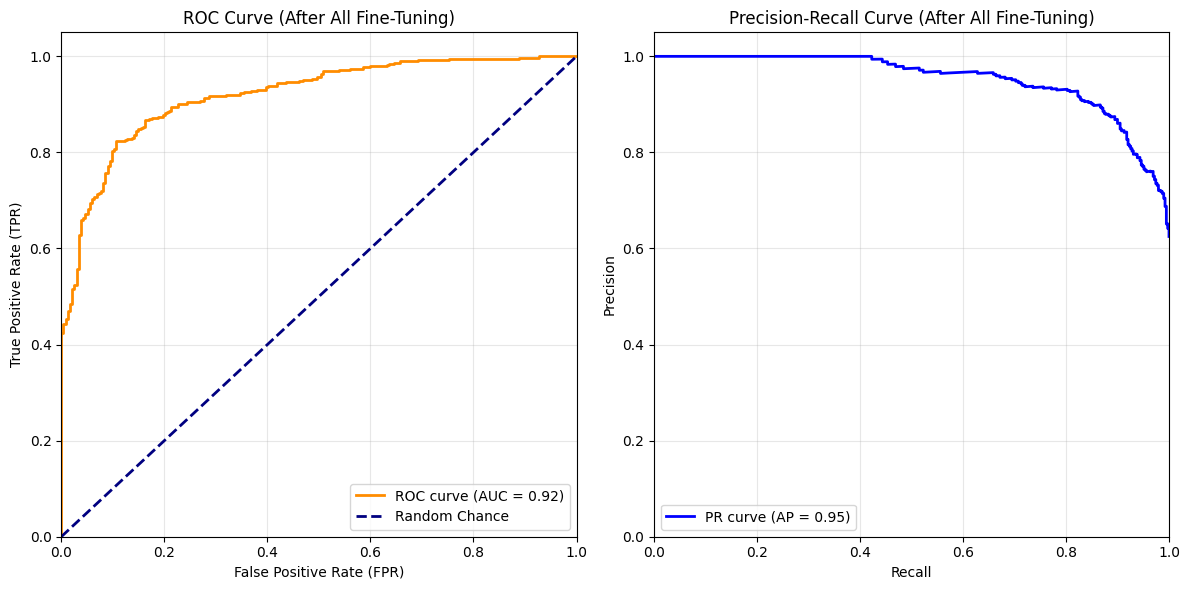

ROC AUC: 0.9196
Average Precision (AP): 0.9530

--- Scalar Metrics @ 0.5 Threshold (After All Fine-Tuning) ---
Confusion Matrix:


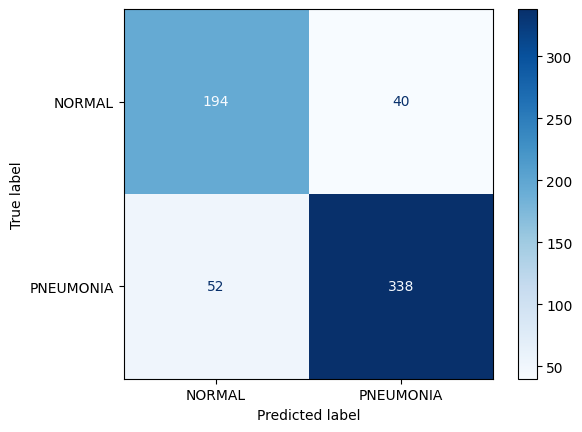

Accuracy: 0.8526
Precision (Pneumonia): 0.8942
Recall (Pneumonia): 0.8667


In [ ]:
print("\n--- Fine-Tuning Phase 1: Training Classifier Head ---")

# Use a smaller number of epochs for the demo
initial_epochs = 3 # Train only the head for a few epochs initially

# The base model layers are already frozen (base_model.trainable = False)
# Model is already compiled with Adam optimizer

print(f"Training the model head for {initial_epochs} epochs...")
start_time = time.time()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # Or your chosen optimizer/LR
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), # Adjust loss if not binary
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

end_time = time.time()
print(f"Phase 1 training completed in {end_time - start_time:.2f} seconds.")

# --- Plot Training History (Optional but Recommended) ---
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(initial_epochs), acc, label='Training Accuracy')
plt.plot(range(initial_epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy (Head Only)')

plt.subplot(1, 2, 2)
plt.plot(range(initial_epochs), loss, label='Training Loss')
plt.plot(range(initial_epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss (Head Only)')
plt.show()

y_pred_proba_final = model.predict(test_dataset)
y_pred_final = (y_pred_proba_final.flatten() >= 0.5).astype(int)

# --- Calculate Metrics & Plot Curves ---
# Use the same true labels (y_true) extracted earlier
# Call the evaluation function for final results
evaluate_and_plot(y_true, y_pred_proba_final, y_pred_final, class_names, title_suffix="(After All Fine-Tuning)")


--- Fine-Tuning Phase 2: Unfreezing Base Layers ---
Base model layers unfrozen from layer 100 onwards.
Model recompiled for fine-tuning with learning rate: 0.0001


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

Continuing training (fine-tuning) for 5 more epochs...
Epoch 4/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 31s 39ms/step - accuracy: 0.9041 - loss: 0.2414 - val_accuracy: 0.5625 - val_loss: 1.2545
Epoch 5/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9917 - loss: 0.0310 - val_accuracy: 0.5000 - val_loss: 2.7133
Epoch 6/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.9998 - loss: 0.0070 - val_accuracy: 0.6250 - val_loss: 1.3364
Epoch 7/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.8125 - val_loss: 1.0260
Epoch 8/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8125 - val_loss: 0.8137
Phase 2 fine-tuning completed in 47.69 seconds.


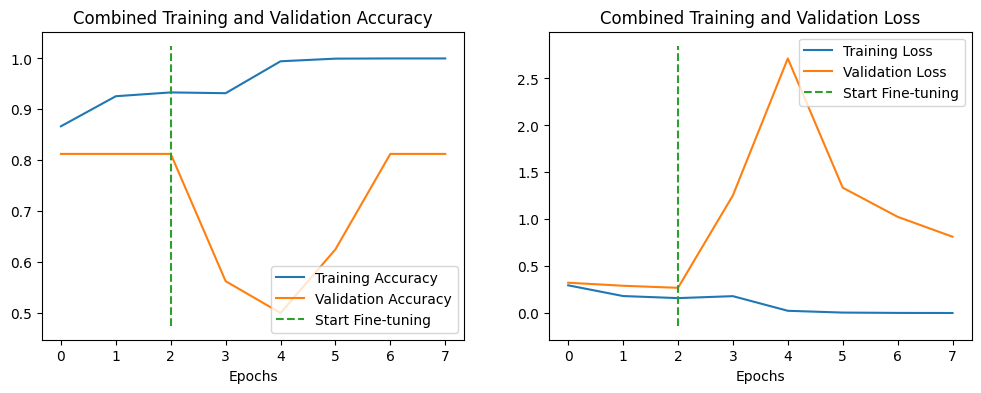

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step

--- Evaluation Results (After All Fine-Tuning) ---


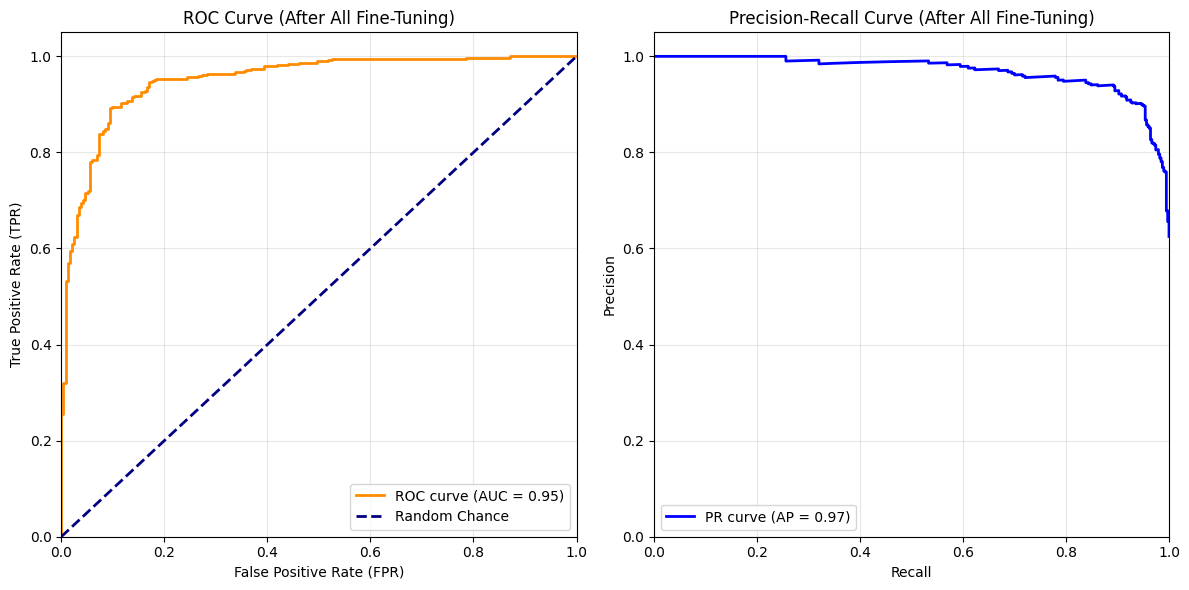

ROC AUC: 0.9513
Average Precision (AP): 0.9688

--- Scalar Metrics @ 0.5 Threshold (After All Fine-Tuning) ---
Confusion Matrix:


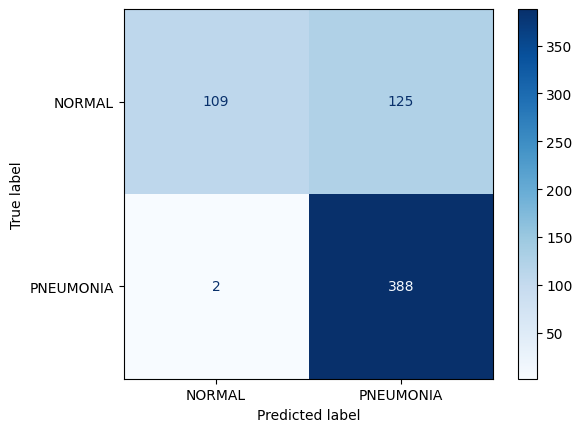

Accuracy: 0.7965
Precision (Pneumonia): 0.7563
Recall (Pneumonia): 0.9949


In [ ]:
print("\n--- Fine-Tuning Phase 2: Unfreezing Base Layers ---")

# --- Unfreeze the base model (or part of it) ---
base_model.trainable = True

# Let's decide how many layers to unfreeze.
# Fine-tune from this layer onwards
# MobileNetV2 has 154 layers. Let's fine-tune the top ~1/3rd.
fine_tune_at = 100 # Unfreeze layers from index 100 onwards

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Base model layers unfrozen from layer {fine_tune_at} onwards.")
# Verify trainable status (optional)
# for i, layer in enumerate(base_model.layers):
#     print(i, layer.name, layer.trainable)

# --- Recompile the model with a lower learning rate ---
# Use a much lower learning rate for fine-tuning
fine_tune_learning_rate = initial_learning_rate / 10 # e.g., 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Model recompiled for fine-tuning with learning rate:", fine_tune_learning_rate)
model.summary() # Note the change in trainable parameters

# --- Continue Training ---
fine_tune_epochs = 5 # Train for a few more epochs
total_epochs = initial_epochs + fine_tune_epochs

print(f"Continuing training (fine-tuning) for {fine_tune_epochs} more epochs...")
start_time = time.time()

# Pass initial_epoch to continue history correctly
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1] + 1, # Start after last epoch of phase 1
                         validation_data=val_dataset)

end_time = time.time()
print(f"Phase 2 fine-tuning completed in {end_time - start_time:.2f} seconds.")


# --- Plot Combined Training History ---
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine-tuning', linestyle='--') # Mark transition
plt.legend(loc='lower right')
plt.title('Combined Training and Validation Accuracy')
plt.xlabel('Epochs')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine-tuning', linestyle='--') # Mark transition
plt.legend(loc='upper right')
plt.title('Combined Training and Validation Loss')
plt.xlabel('Epochs')
plt.show()

y_pred_proba_final = model.predict(test_dataset)
y_pred_final = (y_pred_proba_final.flatten() >= 0.5).astype(int)

# --- Calculate Metrics & Plot Curves ---
# Use the same true labels (y_true) extracted earlier
# Call the evaluation function for final results
evaluate_and_plot(y_true, y_pred_proba_final, y_pred_final, class_names, title_suffix="(After All Fine-Tuning)")
